In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import json
import scipy.signal as sig
import scipy.interpolate as intp
from scipy.ndimage import gaussian_filter

Load in all the data - the file names are included in the json file organized by event (there are 4 of them).

In [2]:
# Read in data, from both Livingston and Haverford, need to specify which event (4 of them)

data_directory = 'LOSC_Event_tutorial/'

with open(data_directory+'BBH_events_v3.json') as file:
    json_dat = json.load(file)

list_events = list(json_dat.keys())
print('Different event names: ', list_events)

Different event names:  ['GW150914', 'LVT151012', 'GW151226', 'GW170104']


In [3]:
# functions from simple_read_ligo.py

def read_template(filename,):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [4]:
# Read in all data, make separate lists for H1,L1 data and templates (templates same for each event)
N_events = len(list_events)
H1_data = [] # data for Hanford events (strain,dt,utc)
L1_data = [] # data for Livingston events
H_templates = [] # templates for Hanford for each event
L_templates = [] # templates for Livingston for each event

for i in range(N_events):
    event_name = str(list_events[i])
    H1_fname = json_dat[event_name]['fn_H1']
    L1_fname = json_dat[event_name]['fn_L1']
    fn_temp = json_dat[event_name]['fn_template']
    H1_data.append(read_file(data_directory+H1_fname))
    L1_data.append(read_file(data_directory+L1_fname))
    H_temp, L_temp = read_template(data_directory+fn_temp)
    H_templates.append(H_temp), L_templates.append(L_temp);
    
file.close() # close json object

In [5]:
H1_dt = [H1_data[i][1] for i in range(N_events)] # get dt for each detector
L1_dt = [L1_data[i][1] for i in range(N_events)]

We can plot the data for each event along with the corresponding template.

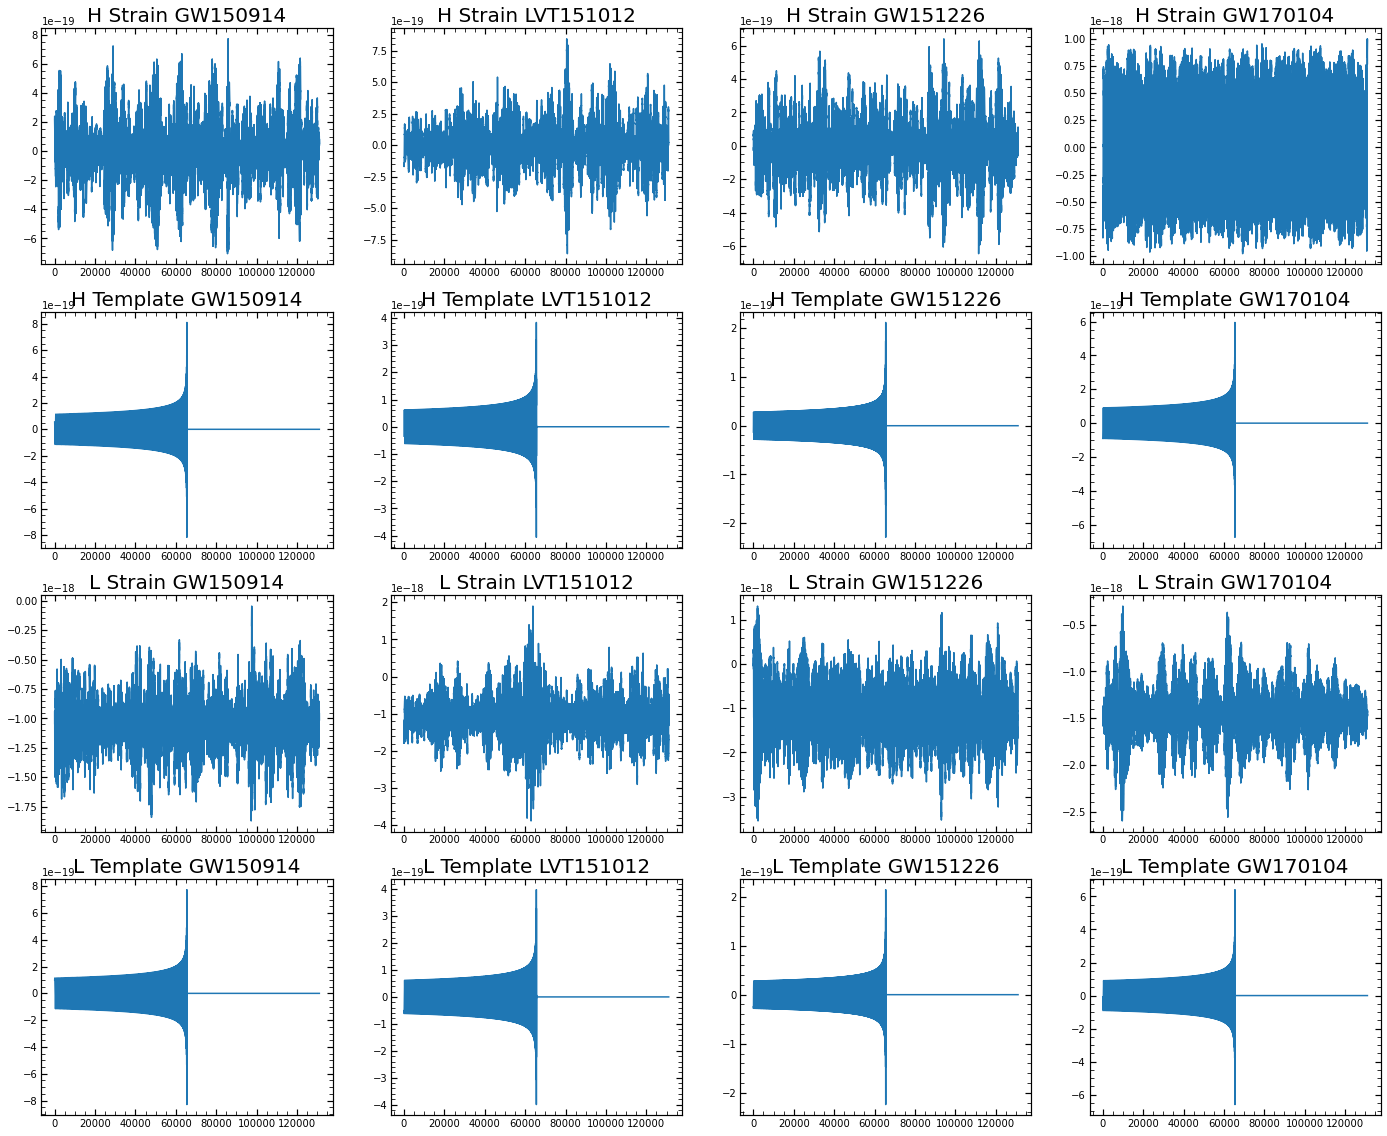

In [6]:
nrows, ncols = 4,4
fig,ax = plt.subplots(nrows,ncols, figsize=[24,20])

for j in range(ncols):
    ax[0,j].plot(H1_data[j][0])
    ax[0,j].set_title('H Strain '+str(list_events[j]), fontsize=20)
    ax[1,j].plot(H_templates[j])
    ax[1,j].set_title('H Template '+str(list_events[j]), fontsize=20)
    ax[2,j].plot(L1_data[j][0])
    ax[2,j].set_title('L Strain '+str(list_events[j]), fontsize=20)
    ax[3,j].plot(L_templates[j])
    ax[3,j].set_title('L Template '+str(list_events[j]), fontsize=20)

# Q1a) Come up with a noise model for the Livingston and Hanford detectors separately. Describe how you do this in comments. Please mention something about how you smooth the power spectrum and how you deal with lines. Please also explain how you window your data (you may want to use a window that has an extended flat period near the centre to avoid tapering the data/template where the signal is not small).

First we can plot the power spectra of each event to get an idea of the the lines that we would like to smooth. We can get the PSD of the strain data (and template) by taking the absolute value of the Fourier transformed squared.

In [94]:
def power_spec(data):
    return np.abs(np.fft.fft(data))**2

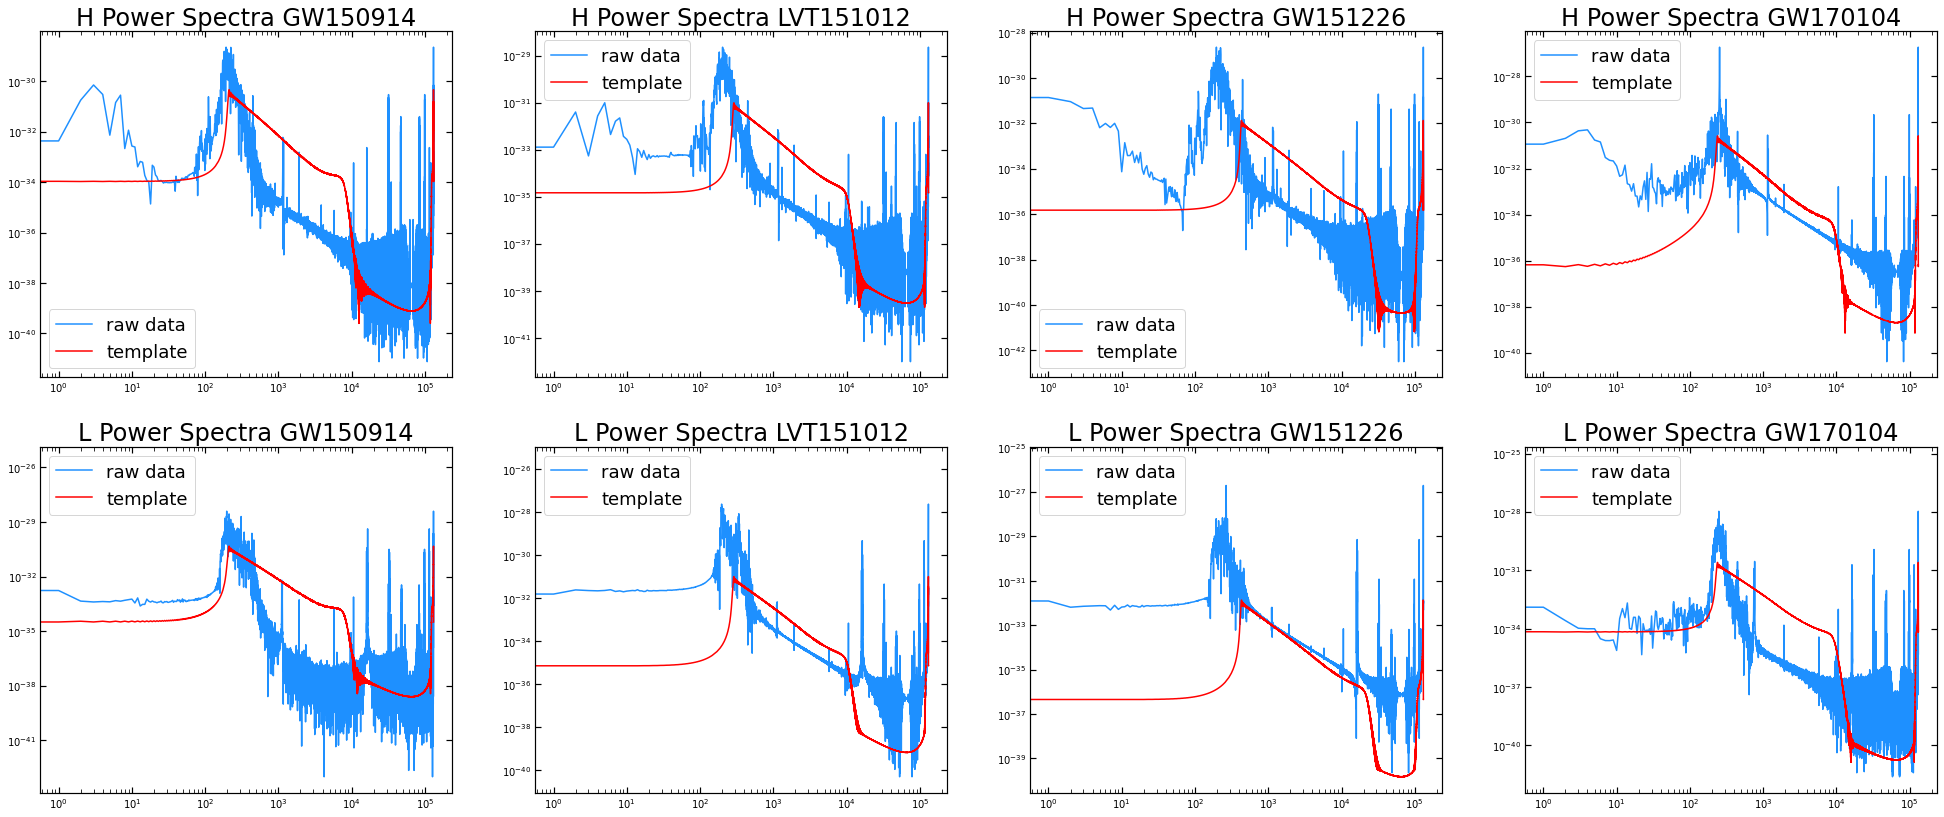

In [95]:
nrows, ncols = 2,4
fig,ax = plt.subplots(nrows,ncols, figsize=[34,14])

for j in range(ncols):
    ax[0,j].loglog(power_spec(H1_data[j][0]), color='dodgerblue', label='raw data')
    ax[0,j].loglog(power_spec(H_templates[j]), color='red', label = 'template')
    ax[0,j].legend(fontsize=18)
    ax[0,j].set_title('H Power Spectra '+str(list_events[j]), fontsize=24)
    ax[1,j].loglog(power_spec(L1_data[j][0]),color='dodgerblue', label='raw data')
    ax[1,j].loglog(power_spec(L_templates[j]),  color='red',label = 'template')
    ax[1,j].legend(fontsize=18)
    ax[1,j].set_title('L Power Spectra '+str(list_events[j]), fontsize=24)

Clearly, the data is very spikey, especially at larger frequencies, so we can try to smooth this out.

One method of doing this is to average over all the power spectra from a given detector's 4 events and apply a window function to minimize the spectral leakage.

Following this, we can convolve the resulting PSD with an extended function to further smooth over some of the spikes/jitteriness in the noise.

Our choice of window function must avoid tapering the data/template where the signal is not very small. After some looking around, it appears like the 'Tukey' or cosine-tapered window will be sufficient for our data. I have plotted the 'Tukey' window function for reference below, next to a plot of it multiplied by the data and finally, a plot of the PSD of the data and template after multiplication by the 'Tukey' function.

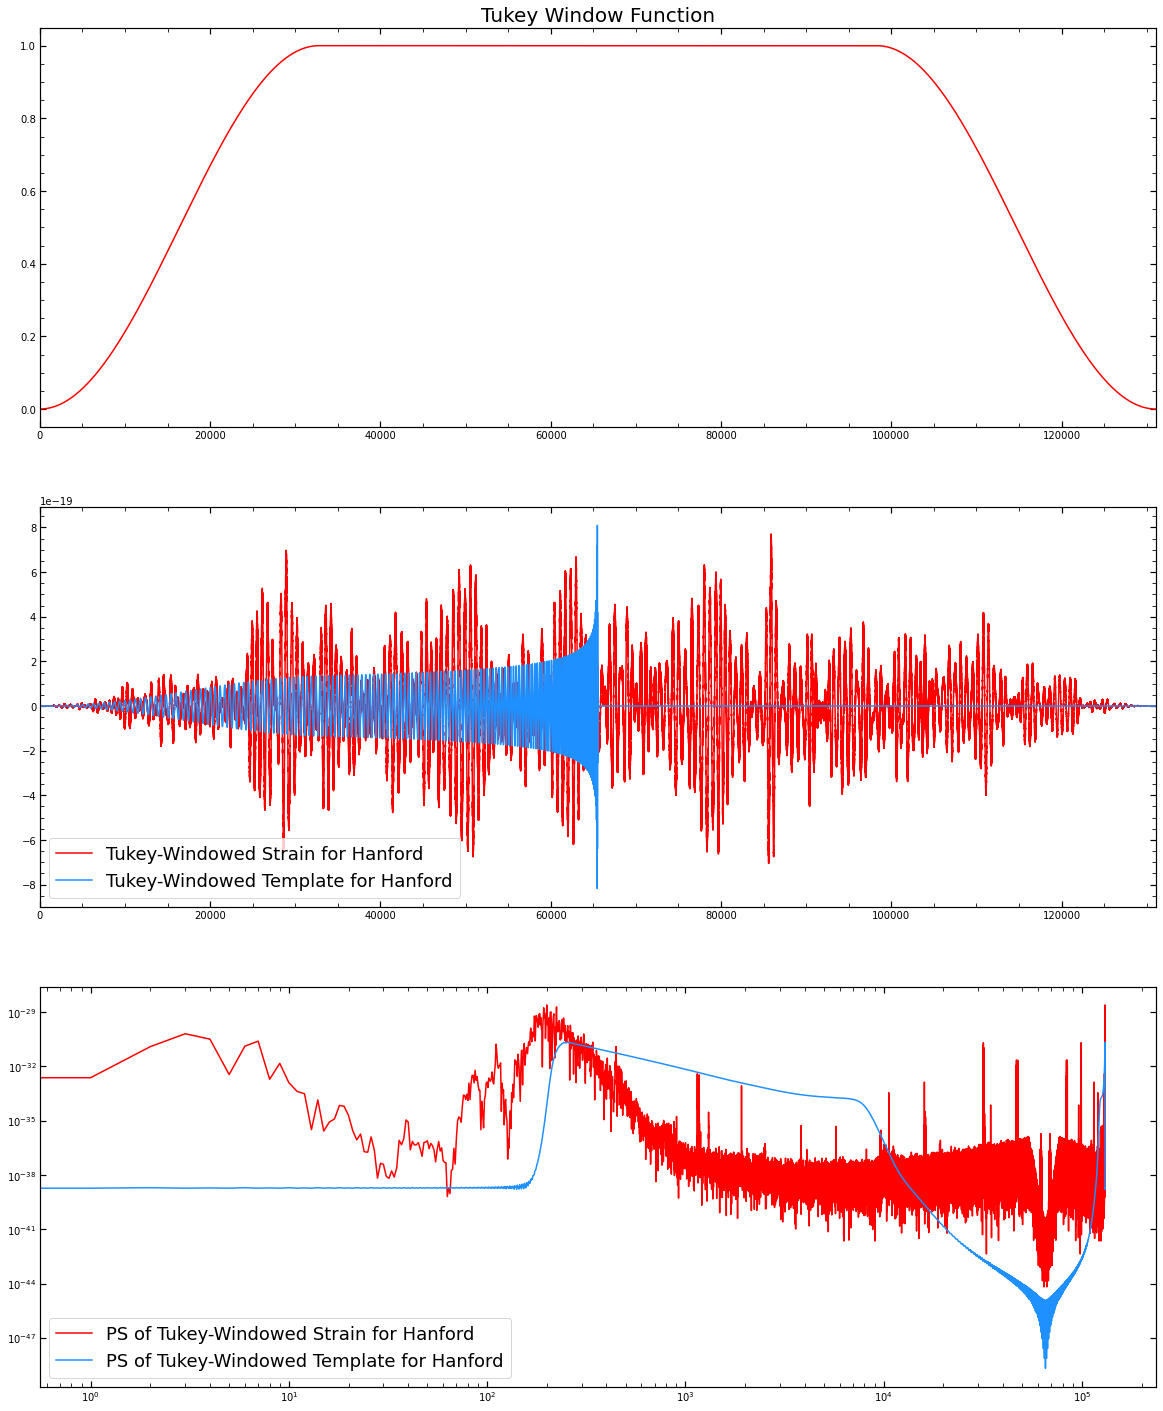

In [11]:
# For first event at Hanford

H1_strain = H1_data[0][0]
Nx = len(H1_strain)
freqs=np.arange(Nx)
tukey = sig.get_window('tukey', Nx=Nx)
H1_strain_tukey = H1_strain*tukey
H_temp_tukey = H_templates[0]*tukey

fig, ax = plt.subplots(3, figsize=[20,25])
ax[0].plot(freqs,tukey,  color='red')
ax[0].set_xlim(xmin=freqs[0], xmax=freqs[-1])
ax[0].set_title('Tukey Window Function',fontsize=20)
ax[1].plot(H1_strain_tukey, color='red', label='Tukey-Windowed Strain for Hanford')
ax[1].plot(H_temp_tukey, color='dodgerblue', label='Tukey-Windowed Template for Hanford')
ax[1].set_xlim(xmin=freqs[0], xmax=freqs[-1])
ax[1].legend(fontsize=18)
ax[2].loglog(power_spec(H1_strain_tukey), color='red', label='PS of Tukey-Windowed Strain for Hanford')
ax[2].loglog(power_spec(H_temp_tukey), color='dodgerblue', label='PS of Tukey-Windowed Template for Hanford')
ax[2].legend(fontsize=18);

Now we can average over the PSDs after multiplication by the window function of the different data sets the two detectors individually, which should all have identical noise models. We will do this separately for each detector. After this, we can convolve our averaged and windowed PSDs with an extended function and obtain our final noise model. In this instance, we will perform a smoothing convolution with a Gaussian.

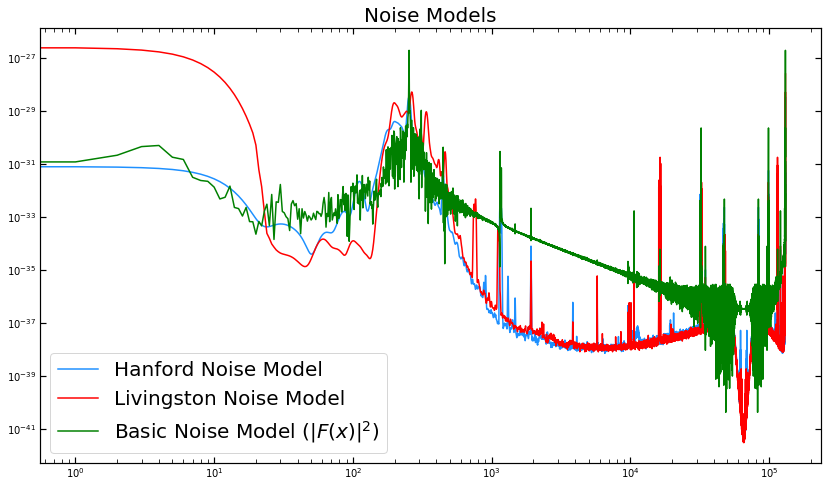

In [12]:
def ave_noise_wind(data_sets): # data sets all of same size
    Nsets = len(data_sets)
    Npt = len(data_sets[0])
    wind = sig.get_window('tukey', Nx=Npt)
    avg_PSD = 0*data_sets[0]
    
    for i in range(Nsets): # average over all events for a given detector
        wind_dat = data_sets[i]*wind
        avg_PSD += power_spec(wind_dat) 
    
    return avg_PSD/Nsets
        
def smooth_conv(power_spec, sigma=5): # convolution to smooth over PSD, with Gaussian
    smoothed_ps = gaussian_filter(power_spec, sigma) # Gaussian filter function takes care of convolution
    return smoothed_ps

def get_noise_model(data_sets):
    ave_wind_noise_ps = ave_noise_wind(data_sets)
    smooth_noise_ps = smooth_conv(ave_wind_noise_ps)
    return smooth_noise_ps

H_strain = [H1_data[i][0] for i in range(N_events)] # strain for each event
L_strain = [L1_data[j][0] for j in range(N_events)]

# Now our noise models for Hanford and Livingston

H1_noise_mod = get_noise_model(H_strain)
L1_noise_mod =  get_noise_model(L_strain)

fig, ax = plt.subplots(figsize=[14,8])

ax.loglog(H1_noise_mod, color = 'dodgerblue', label='Hanford Noise Model')
ax.loglog(L1_noise_mod, color = 'red', label='Livingston Noise Model')
ax.loglog(power_spec(H1_data[j][0]), color='green', label='Basic Noise Model ($|F(x)|^2$)')
ax.legend(fontsize=20)
ax.set_title('Noise Models', fontsize=20);

# Q1b) Use the noise model to search for four sets of events using a matched filter. The mapping between data and templates can be found in the json file.

Now we can apply the matched filter method, although filter we will need to pre-whiten the template ($A$) and the data ($d$). We will do this by windowing and multiplying the strain and template by $N^{-1/2}$, after which we can apply the matched filter formula, $MF = F^{-1}[F(\tilde{A}) \star F(\tilde{d})]$.

In [79]:
def pre_whiten(data, noise):
    fft_dat_wind = np.fft.fft(data*sig.get_window('tukey', Nx=len(data))) # Tukey window
    white_fft_dat_wind = fft_dat_wind/np.sqrt(noise) # whiten with Noise model
    white_data = np.fft.ifft(white_fft_dat_wind) # inverse transform back to get whitened strain
    return white_data

def matched_filter(data, template, noise): # following matched filter formula, use whitened strain, template
    white_data = pre_whiten(data,noise)
    white_temp = pre_whiten(template,noise)
    fft_white_data = np.fft.fft(white_data)
    conj_fft_white_temp = np.conjugate(np.fft.fft(white_temp)) # take conjugate for convolution
    MF = np.real(np.fft.ifft(fft_white_data*conj_fft_white_temp)) # convolve whitened data and conj whitenend template
    return MF

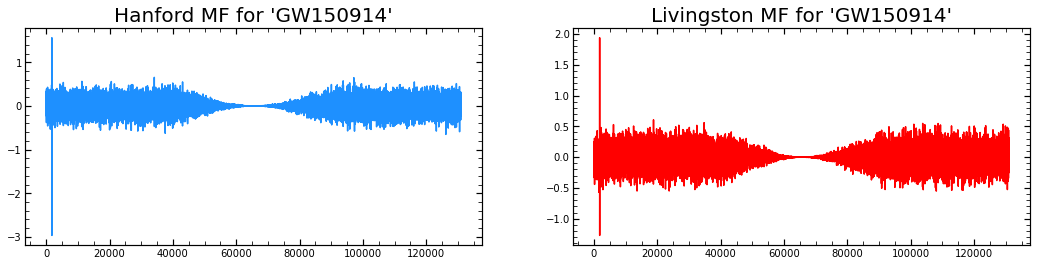

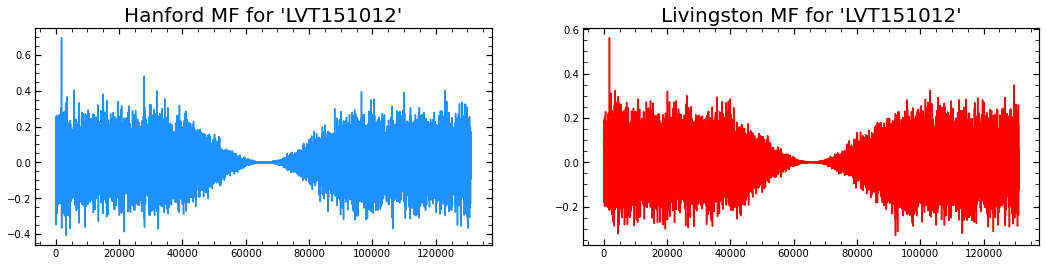

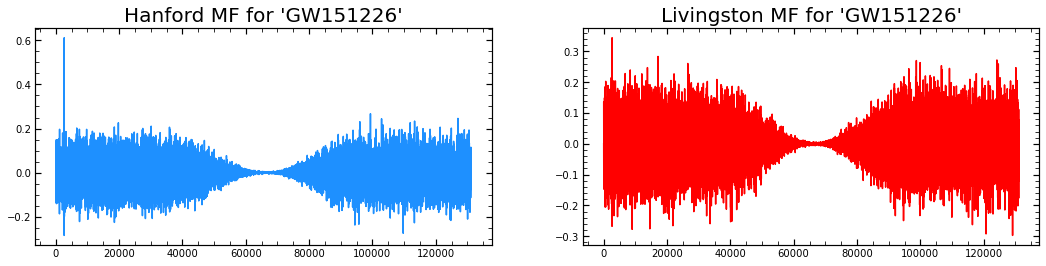

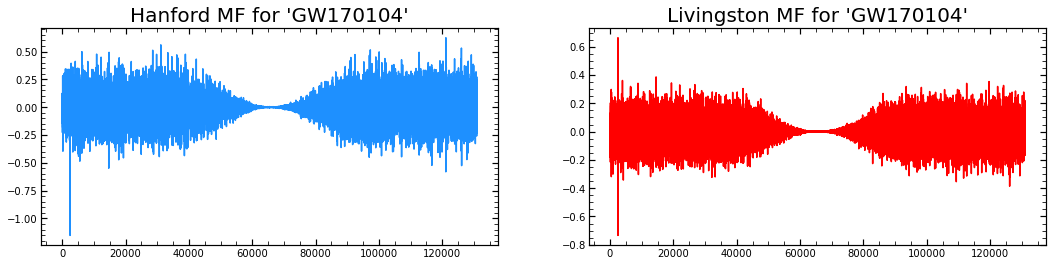

In [26]:
H1_mf = [] # list of all Matched Filters for each event
L1_mf = []

for i in range(N_events): # plot MF for each event at both detectors
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18, 4))
    H_mf = matched_filter(H_strain[i],H_templates[i], H1_noise_mod)
    H1_mf.append(H_mf)
    L_mf = matched_filter(L_strain[i],L_templates[i], L1_noise_mod)
    L1_mf.append(L_mf)
    ax[0].plot(H_mf, color='dodgerblue', label = 'Hanford')
    ax[1].plot(L_mf, color='red', label='Livingston')
    ax[0].set_title('Hanford MF for ' +repr(list_events[i]), fontsize=20)
    ax[1].set_title('Livingston MF for ' +repr(list_events[i]), fontsize=20)

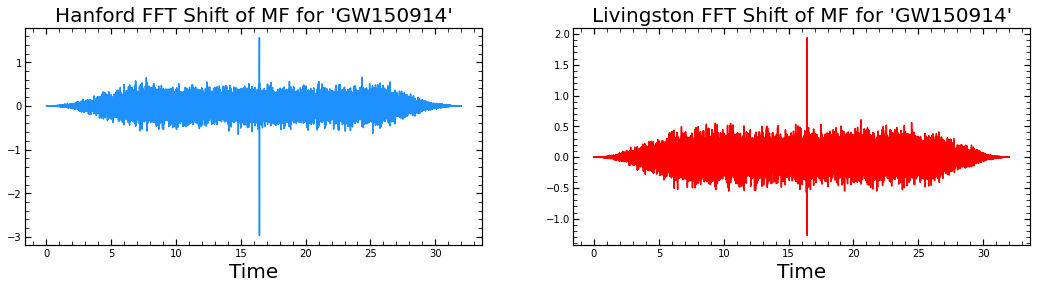

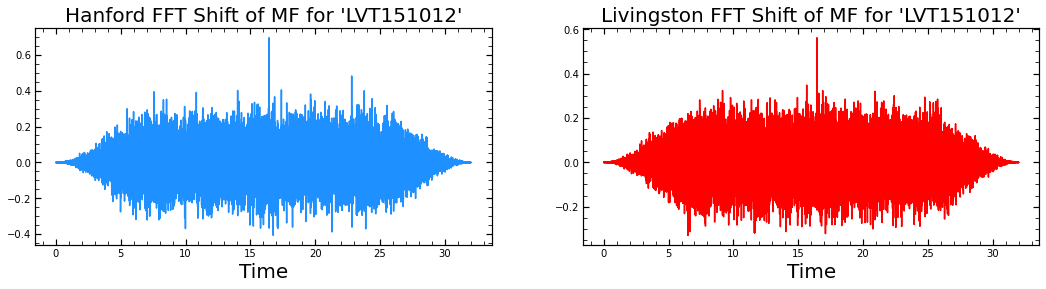

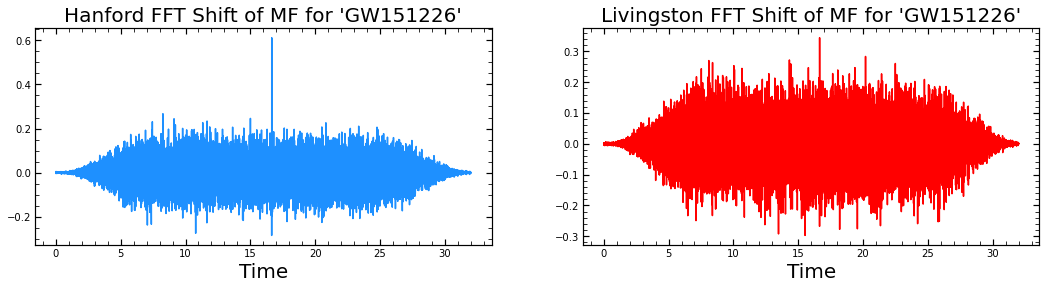

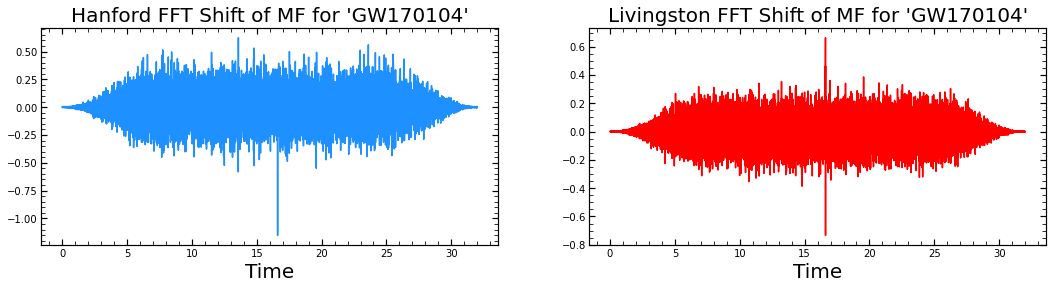

In [27]:
# Compute the FFT shift of the matched filter output as we saw in class - easier to see potential GWs

for i in range(N_events):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18, 4))
    H_t = np.arange(0, len(H_strain[i])*H1_dt[i], H1_dt[i]) # need time domain
    L_t = np.arange(0, len(L_strain[i])*L1_dt[i], L1_dt[i])
    H_shift_t = np.fft.fftshift(H_t) # shift time domain
    L_shift_t = np.fft.fftshift(L_t)
    ax[0].plot(H_shift_t, H1_mf[i], color='dodgerblue', label = 'Hanford')
    ax[1].plot(L_shift_t, L1_mf[i], color='red', label='Livingston')
    ax[0].set_title('Hanford FFT Shift of MF for ' +repr(list_events[i]), fontsize=20)
    ax[1].set_title('Livingston FFT Shift of MF for ' +repr(list_events[i]), fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)

Clearly, there are some detections that have occurred, with some events more obvious than others.

# Q1c) Estimate a noise for each event, and from the output of the matched filter, give a signal-to-noise ratio for each event, both from the individual detectors, and from the combined Hanford and Livingston events.

To compute the SNR, we can find the 'noise' part of the ratio as the standard deviation in the matched filter for each event, and we can take the 'signal' part of this ratio as the maxima of the absolute value of the matched filter for each event (this will give us the maximum SNR for a given event and detector). Combining the two SNRs from the 2 detectors for each event added in quadrature given the two detectors should be independent of each other, we can calculate the combined SNR for each event. However, when we estimate the noise, we want to ensure that the actual signal is not included in the standard deviation calculation and therefore, we can find a suitable range of the MF where the signals are not present based on where we know the signal is present (maxima of shifted time MF).

In [28]:
def get_SNR(mf):
    mf_max_ind = np.argmax(np.abs(mf)) # index of maximum signal 
    mf_N_low_ind, mf_N_high_ind = mf_max_ind+1500, mf_max_ind+6500 # take over interval without signal
    N = np.std(mf[mf_N_low_ind:mf_N_high_ind])
    S = np.abs(mf[mf_max_ind])
    SNR = S/N # maximum SNR
    return SNR, N

In [29]:
for i in range(N_events): # find SNR for each event, detector, combined
    H1_SNR, H1_noise = get_SNR(H1_mf[i])
    L1_SNR, L1_noise = get_SNR(L1_mf[i])
    overall_SNR = np.sqrt(H1_SNR**2 + L1_SNR**2)
    print('{}: Hanford N = {:.3f} and SNR = {:.2f}; Livingston N = {:.3f} and SNR = {:.2f} and combined SNR = {:.2f}'.format(list_events[i], H1_noise, H1_SNR, L1_noise, L1_SNR, overall_SNR))  

GW150914: Hanford N = 0.160 and SNR = 18.55; Livingston N = 0.152 and SNR = 12.75 and combined SNR = 22.51
LVT151012: Hanford N = 0.099 and SNR = 7.00; Livingston N = 0.102 and SNR = 5.53 and combined SNR = 8.92
GW151226: Hanford N = 0.061 and SNR = 10.00; Livingston N = 0.076 and SNR = 4.56 and combined SNR = 10.99
GW170104: Hanford N = 0.140 and SNR = 8.21; Livingston N = 0.096 and SNR = 7.66 and combined SNR = 11.23


# Q1d) Compare the SNR you get from the scatter in the matched filter to the analytic SNR you expect from your noise model. How close are they? If they disagree, can you explain why?

The analytic SNR from our noise model can be written as, 

\begin{equation}
\text{SNR} = \sqrt{(A^T N^{-1} A)}
\end{equation}

where $A$ is the FFT of the template for each event, and $N$ our noise model for a given detector. However, if we take the FFT of the prewhitened template $\tilde{A}$, which is already divided by a factor of $N^{1/2}$, our SNR can be rewritten as $F^{-1}[\sqrt{\tilde{A}^T \tilde{A}} ]$.

In [98]:
def analytic_SNR(template, noise):
    template_white = pre_whiten(template, noise) # prewhiten
    fft_template_white = np.fft.fft(template_white) # FFT of prewhitened template
    fft_SNR = (fft_template_white.conjugate()*fft_template_white)**(1/2) # transpose is conjugate
    SNR = np.max(np.real(np.fft.ifft(fft_SNR))) # find maximum SNR
    return SNR

In [99]:
for i in range(N_events): # SNR for each event, detector, and combined
    H1_analyt_SNR = analytic_SNR(H_templates[i], H1_noise_mod)
    L1_analyt_SNR = analytic_SNR(L_templates[i], L1_noise_mod)
    overall_analyt_SNR = np.sqrt(H1_analyt_SNR**2 + L1_analyt_SNR**2)
    print('{}: Hanford analytic SNR = {:.2f}; Livingston analytic SNR = {:.2f} and combined SNR = {:.2f}'.format(list_events[i],H1_analyt_SNR, L1_analyt_SNR, overall_analyt_SNR))  

GW150914: Hanford analytic SNR = 16.92; Livingston analytic SNR = 15.67 and combined SNR = 23.06
LVT151012: Hanford analytic SNR = 11.09; Livingston analytic SNR = 10.38 and combined SNR = 15.19
GW151226: Hanford analytic SNR = 8.40; Livingston analytic SNR = 8.06 and combined SNR = 11.64
GW170104: Hanford analytic SNR = 14.28; Livingston analytic SNR = 13.33 and combined SNR = 19.53


The SNRs calculated from the scatter in the matched filter are relatively close to those calculated analytically from the template and noise model, as they are all of the same order of magnitude, although Events 2 and 4 are nearly 2 times larger than the corresponding SNRs calculated form the scatter. Given we do not include the data in our calculation of the analytic SNR (we only consider the template and noise), whilst we used the data to calculate the MF from which the estimated SNR is derived, we have avoided situations where the matched filter performs poorly. Therefore, we would intuitively expect that for a given noise model, the SNR would be maximized by only considering the template, given any data set will not agree with the template more than the template itself, so the MF-derived SNR will be smaller. 

# Q1e) From the template and the noise model, find the frequency from each event where half the weight comes from above that frequency and half below.

We can do this by taking the cumulative sum at which FFT of the pre-whitened template and find the frequency where this cumulative sum is equal to half of the total sum, otherwise known as the frequency at which half the weight occurs.

In [102]:
def freq_half_weight(template, noise, freq):
    temp_white = pre_whiten(template, noise) # prewhitened template
    fft_temp_white = np.fft.rfft(temp_white)
    normcum_fft_temp_white = np.cumsum(np.abs(fft_temp_white)) / np.sum(np.abs(fft_temp_white)) # normed cumulative sum
    half_weight_ind = np.where(normcum_fft_temp_white>=0.5)[0][0] # find index at which greater than 0.5
    return freq[half_weight_ind]

In [103]:
for i in range(4):
    H_freq = np.fft.rfftfreq(len(H_strain[i]), H1_dt[i])
    L_freq = np.fft.rfftfreq(len(L_strain[i]), L1_dt[i])
    print('Event {}: half-weight frequency for Hanford = {:.2f} Hz, Livingston = {:.2f} Hz'.format(list_events[i], freq_half_weight(H_templates[i], H1_noise_mod, H_freq), freq_half_weight(L_templates[i], L1_noise_mod, L_freq)))

Event GW150914: half-weight frequency for Hanford = 124.50 Hz, Livingston = 134.69 Hz
Event LVT151012: half-weight frequency for Hanford = 118.38 Hz, Livingston = 132.53 Hz
Event GW151226: half-weight frequency for Hanford = 140.56 Hz, Livingston = 159.69 Hz
Event GW170104: half-weight frequency for Hanford = 123.44 Hz, Livingston = 135.38 Hz


# Q1f) How well can you localize the time of arrival (horizontal shift of your matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainty you might expect given that the detectors are a few thousand $km$ apart.

We know that gravitational waves travel at the speed of light $c$, so for a pair of detectors located $\approx 10^3 \, km$, we would expect that the typical positional uncertainty (in time, which we plotted in the FFT shift of the MF) is on the order of, 

\begin{equation}
\delta t \approx \frac{10^6 \ m}{3*10^8 \, \frac{m}{s}} \approx 3.33*10^{-3} \, s.
\end{equation}

We can calculate the time difference between the two detectors for each event, and compare this to this expected value.

In [106]:
time_diffs = np.zeros(N_events)
for i in range(N_events): # need time shifted domain as we did above
    H_t = np.arange(0, len(H_strain[i])*H1_dt[i], H1_dt[i]) 
    L_t = np.arange(0, len(L_strain[i])*L1_dt[i], L1_dt[i])
    H_shift_t = np.fft.fftshift(H_t)
    L_shift_t = np.fft.fftshift(L_t)
    H_max_ind = np.argmax(np.abs(H1_mf[i]))
    L_max_ind = np.argmax(np.abs(L1_mf[i]))
    time_diffs[i] = np.abs(H_shift_t[H_max_ind] - L_shift_t[L_max_ind])
    print('Difference in time between signal detections for event ',list_events[i], ' is ' , time_diffs[i], ' sec.')
print('The averaged time uncertainty is ', np.round(time_diffs.mean(), 6), 'sec.')
print('The averaged positional uncertainty is ', np.round(3e5*time_diffs.mean(), 2), 'km.')

Difference in time between signal detections for event  GW150914  is  0.009033203125  sec.
Difference in time between signal detections for event  LVT151012  is  0.001953125  sec.
Difference in time between signal detections for event  GW151226  is  0.00048828125  sec.
Difference in time between signal detections for event  GW170104  is  0.004638671875  sec.
The averaged time uncertainty is  0.004028 sec.
The averaged positional uncertainty is  1208.5 km.


As expected, the time uncertainty is on the order of magnitude we calculated from the estimate above given gravitational waves travel at the speed of light.